# Model training pipeline in a single tasty wrap: `do_datasciencing`

In this tutorial, we will not use the functions above directly but instead, we will examine their wrapper - the function `datasciencefunctions.classification.do_datasciencing`.

The idea behind `do_datasciencing` is to provide a quick way to explore model ideas and quickly productionize standard models. It allows beginner users to train models in a correct way quickly and it allows experienced users to skip a lot of repetitive code when dealing with standard modelling tasks. Ultimately the `do_datasciencing` is a model training pipeline wrapped up in a single function - with it, the user can train a model (with cross-validation based hyperparameter selection), get the model summary containing most important information about the model and (optionally) log the model and the summary to MLFlow.

In a later tutorial, we will se how to unwrap do_datasciencing to use its components mentioned above in a modular and customized fashion when the standard approach is not enough.

We will now import `datasciencefunctions` as `ds` and in the rest of this tutorial we will sometimes refer to `datasciencefunctions` as `ds` when discussing the modules of the package and their functions

In [0]:
import datasciencefunctions as ds
import datasciencefunctions.classification as dsclass

#0. Load and prepare data

#### 
* We will load the adult databricks example dataset. 
* It contains categorical, ordinal and numeric (continuous) predictors representing demographic info of US adults and a target denoting whether their income exceeded USD 50 000. 
* We want to train a model to predict whether the person's income exceeds USD 50 000. 
(you can read more details in the readme below).

In [0]:
with open("/dbfs/databricks-datasets/adult/README.md") as f:
    x = ''.join(f.readlines())

print(x)

=============================================================
Adult Dataset
=============================================================
Predict whether income exceeds $50K/yr based on census data. Also known as "Census Income" dataset.

## Source

Donor: 
Ronny Kohavi and Barry Becker 
Data Mining and Visualization 
Silicon Graphics. 
e-mail: ronnyk '@' live.com for questions.

## Data Set Information:
Extraction was done by Barry Becker from the 1994 Census database. A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0)) 

Prediction task is to determine whether a person makes over 50K a year.

## Attribute Information

Label:
	- >50K, <=50K

Attributes:

	- age: continuous
	- workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked
	- fnlwgt: continuous
	- education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool
	- education-num: continuous
	- marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse
	- occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces
	- relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried
	- race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black
	- sex: Female, Male
	- capital-gain: continuous
	- capital-loss: continuous
	- hours-per-week: continuous
	- native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands

## Citation
If you publish material based on databases obtained from this repository, then, in your acknowledgements, please note the assistance you received by using this repository. This will help others to obtain the same data sets and replicate your experiments. We suggest the following pseudo-APA reference format for referring to this repository:

Lichman, M. (2013). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

In [0]:
schema = """
  age DOUBLE,
  workclass STRING,
  fnlwgt DOUBLE,
  education STRING,
  education_num DOUBLE,
  marital_status STRING,
  occupation STRING,
  relationship STRING,
  race STRING,
  sex STRING,
  capital_gain DOUBLE,
  capital_loss DOUBLE,
  hours_per_week DOUBLE,
  native_country STRING,
  income STRING
"""

df_adult = (
    spark
    .read
    .format("csv")
    .schema(schema)
    .option("header", True)
    .option("path", "dbfs:/databricks-datasets/adult/adult.data")
    .load()
    .sample(fraction=0.35) # only take a sample of the dataset for tutorial purposes
)

df_adult.printSchema()

root
-- age: double (nullable = true)
-- workclass: string (nullable = true)
-- fnlwgt: double (nullable = true)
-- education: string (nullable = true)
-- education_num: double (nullable = true)
-- marital_status: string (nullable = true)
-- occupation: string (nullable = true)
-- relationship: string (nullable = true)
-- race: string (nullable = true)
-- sex: string (nullable = true)
-- capital_gain: double (nullable = true)
-- capital_loss: double (nullable = true)
-- hours_per_week: double (nullable = true)
-- native_country: string (nullable = true)
-- income: string (nullable = true)

When running binary classification, datasciencefunctions expects you to specify a label (or target) column with values 1 and 0.

We will create a classification target column called "income_above_50K" with value 1 if the person's income exceeds USD 50K and 0 otherwise.

In [0]:
import pyspark.sql.functions as F

df_adult_ml = (
    df_adult
    .withColumn(
        "income_above_50K", 
        F.when(F.col("income")==" >50K", 1).otherwise(0)
    )
    # we drop the income column because it is perfectly correlated with our label
    .drop("income")
)

In [0]:
display(df_adult_ml.limit(10))

age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_above_50K
50.0,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,0
38.0,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,0
37.0,Private,284582.0,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,0
23.0,Private,122272.0,Bachelors,13.0,Never-married,Adm-clerical,Own-child,White,Female,0.0,0.0,30.0,United-States,0
32.0,Private,186824.0,HS-grad,9.0,Never-married,Machine-op-inspct,Unmarried,White,Male,0.0,0.0,40.0,United-States,0
56.0,Local-gov,216851.0,Bachelors,13.0,Married-civ-spouse,Tech-support,Husband,White,Male,0.0,0.0,40.0,United-States,1
54.0,?,180211.0,Some-college,10.0,Married-civ-spouse,?,Husband,Asian-Pac-Islander,Male,0.0,0.0,60.0,South,1
45.0,Private,386940.0,Bachelors,13.0,Divorced,Exec-managerial,Own-child,White,Male,0.0,1408.0,40.0,United-States,0
22.0,State-gov,311512.0,Some-college,10.0,Married-civ-spouse,Other-service,Husband,Black,Male,0.0,0.0,15.0,United-States,0
48.0,Private,242406.0,11th,7.0,Never-married,Machine-op-inspct,Unmarried,White,Male,0.0,0.0,40.0,Puerto-Rico,0


#1. Basic use of `do_datasciencing`
The function `ds.classification.do_datasciencing` is a wrapper of several other functions which allows the user to train a model (with cross-validation based hyperparameter selection) and get a summary of its basic performance metrics in a few lines of code. It can also log the model and its summary to MLFlow experiments. It is designed for quick pilot/PoC models and model explorations, but with a few optional parameters it can be used in a more "productionized" way when applied to standard models.

In a later chapter of the tutorial, we will se how to unwrap `do_datasciencing` to use its components in a modular and customized fashion when the standard approach is not enough.


Since we already have a dataset ready for machine learning ([a hyperlink here to a tutorial for data exploration](link)), all we need to do is to import the classification module of the  datasciencefunctions library and run a single function.

### Basic input for `do_datasciencing`

We will use the function `do_datasciencing` to train a quick model. All we need are 3 input data:
1. The dataset with features and a label/target column (either a PySpark or a Pandas dataframe), here called `df_adult_ml`
2. A model used for training. Default available models can be found as instances of the `datasciencefunctions.MlModel` class. It is also possible to register custom instances of that class (i.e. custom models), more on that later...
3. The name of the label/target colum. By default, the name `label` is used, if your label column has a different name (as in our case) it needs to be specified with the `label_col` parameter

### Standard classification models in `MlModel`

The following are the basic models available in `datasciencefunctions.MlModel` (they are also visible for example in Databricks or Jupyter notebooks by typing `datasciencefunctions.MlModel.` and pressing TAB)

In [0]:
for model_type in ds.MlModel:
    print(model_type)

spark_logistic_regression
spark_GBT_classifier
spark_decision_tree_classifier
spark_random_forest_classifier
spark_GLM_binomial
sklearn_random_forest_classifier

### The output of `do_datasciencing`

Let us train a logistic regression model (using the generalized linear model with a binomial family) on our dataset. We called our label `income_above_50K` so we need to specify that.

The `do_datasciencing` function returns three objects:
1. `transformed_train_data`
2. `transformed_test_data`
3. `model_summary`

For Spark models, `transformed_train_data` and `transformed_test_data` are training and testing dataframes with preprocessed and vectorized features, by default split at random with a `0.7` ratio. The user can apply the model to them directly to check the results. For sklearn models, they follow standard conventions of `(X, y)` pairs where `X` are input features (including preprocessing) and `y` is predicted value.

The `summary` contains the model itself, the preprocessing pipeline and complete pipeline (both preprocessing and model together) as well as most common statistics about the model&hellip; more on that soon.

In [0]:
help(dsclass.do_datasciencing)

Help on function do_datasciencing in module datasciencefunctions._classification:

do_datasciencing(df, model_type: datasciencefunctions._MlModel.MlModel, use_mlflow: bool = True, label_col: str = 'label', skip_cols: list = None, params_get_cat_num_columns: dict = None, params_fit_pipeline: dict = None, params_split: dict = None, params_fit_model: dict = None)
 .. Note:: This function has the following packages as optional dependencies: mlflow
 
 
 Run default end-to-end ML pipeline on a feature data set.
 
 Currently binary classification in Spark and sklearn (on top of Pandas)
 is supported.
 
 Takes a dataframe, prepares it for machine learning, splits to train and
 test set, fits preprocessing pipeline on training data, fits model
 hyperparameters using given optimization technique, calculates various
 model properties, artifacts, and metrics and logs them to mlflow (if
 :param use_mlflow is specified). Please note that tracking URI and
 experiment should be set in MLflow in advance.
 
 This is just a wrapper. To achieve greater flexibility (e.g. custom
 train/test split or data wrangling), you can start from this function's
 implementation and/or provided examples and adjust the necessary parts
 according to your needs.
 
 Parameters starting with `params_` are passed into relevant functions.
 Some of their parameters are not supported (e.g. data since it will be
 supplied from previous steps inside of this function). In such a case,
 parameter will simply be ignored and warning will be written to logs.
 
 .. Note:: this function disables automatic tracking and only logs the
 final model so that the experiment is not polluted with exceeding
 amount of models with no data about them
 
 :param df: dataset containing features to be used for model training
 :param model_type: model type from MlModel
 :param use_mlflow: if set to True, log model, metrics, etc. to MLflow
 :param label_col: name of column to use as label/target values
 :param skip_cols: columns to be removed from consideration in
 preprocessing pipeline and model training
 :type skip_cols: list of strings
 :param params_get_cat_num_columns: parameters passed to
 get_categorical_and_numeric_cols
 :param params_fit_pipeline: parameters passed to fit_transformation_pipeline
 :param params_split: parameters passed to train_test_split
 :param params_fit_model: parameters passed to fit_classification_model
 
 :return: transformed train data, transformed test data, model summary

In [0]:
df_train, df_test, model_summary = (
    dsclass.do_datasciencing(
        df_adult_ml,
        model_type=ds.MlModel.spark_GLM_binomial,
        # we specify the label colum name
        # this can be omitted when the label column is called "label" 
        label_col="income_above_50K",
        params_fit_model={
            "max_evals": 2,  # just to make it faster
        },
    )
)

/databricks/spark/python/pyspark/sql/context.py:77: DeprecationWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
 DeprecationWarning)
 0%| | 0/2 [00:00<?, ?trial/s, best loss=?] /databricks/spark/python/pyspark/ml/util.py:758: UserWarning: MLflow auto-tracking of MLlib tuning is currently disabled. To enable this feature, set the flag via `spark.conf.set('spark.databricks.mlflow.trackMLlib.enabled', 'true')` where `spark` is your SparkSession.
 warnings.warn(_MLflowInstrumentation._MLFLOW_TRACKING_DISABLED_MESSAGE)

 0%| | 0/2 [00:00<?, ?trial/s, best loss=?] 50%|█████ | 1/2 [00:29<00:29, 29.37s/trial, best loss: -0.8835242283620035]100%|██████████| 2/2 [00:50<00:00, 26.96s/trial, best loss: -0.8894059074328825]100%|██████████| 2/2 [00:50<00:00, 25.36s/trial, best loss: -0.8894059074328825]

The `do_datasciencing` function uses a hyperopt hyperparameter search (more on that later) by default with the search space specified in `MlModel` (but customizable, more on that also later). During training, you can watch as the best loss (defined as `-AUROC` on the test set, where `AUROC` stands for Area Under ROC curve) changes.
Afterwards, you will mostly want to look at the summary...

#2. The training summary

In [0]:
from pprint import pprint
pprint(model_summary)

{'artifacts': {'coefficients': {'age': {'p_value': 0.0,
 'std_err': 0.002654062371818439,
 't_value': 11.303879917860593,
 'value': 0.030001202345547904},
 'capital_gain': {'p_value': 0.0,
 'std_err': 1.9678243416633804e-05,
 't_value': 16.361271164989176,
 'value': 0.00032196107659020873},
 'capital_loss': {'p_value': 0.0,
 'std_err': 6.732735917530944e-05,
 't_value': 8.809956308892813,
 'value': 0.0005931510927276098},
 'education_num': {'p_value': 0.0,
 'std_err': 0.013469956861771257,
 't_value': 23.105949886143634,
 'value': 0.3112361482166032},
 'fnlwgt': {'p_value': 0.8092598583162502,
 'std_err': 3.093761491092642e-07,
 't_value': 0.2413809728212712,
 'value': 7.467751583969285e-08},
 'hours_per_week': {'p_value': 0.0,
 'std_err': 0.002783851420411058,
 't_value': 12.348354551248137,
 'value': 0.03437598435723148},
 'intercept': {'p_value': 0.0,
 'std_err': 0.2516532202966224,
 't_value': -31.120744547887426,
 'value': -7.831635583504425},
 'marital_status_encoded_ Divorced': {'p_value': 0.0023127715083162137,
 'std_err': 0.04031392365319154,
 't_value': -3.0468187111841347,
 'value': -0.12282921690779264},
 'marital_status_encoded_ Married-civ-spouse': {'p_value': 0.0,
 'std_err': 0.03884638220761187,
 't_value': 11.42476661913105,
 'value': 0.44381085071953047},
 'marital_status_encoded_ Married-spouse-absent': {'p_value': 0.738294883877648,
 'std_err': 0.04296962351448285,
 't_value': -0.33411221380462186,
 'value': -0.014356676038775001},
 'marital_status_encoded_ Never-married': {'p_value': 3.4324498798810055e-10,
 'std_err': 0.0398945330605005,
 't_value': -6.277868962878567,
 'value': -0.250452650889049},
 'marital_status_encoded_ Separated': {'p_value': 0.6007690274808732,
 'std_err': 0.042630993953964774,
 't_value': -0.5232949316586072,
 'value': -0.02230858306767849},
 'marital_status_encoded_ Widowed': {'p_value': 0.3698497481387486,
 'std_err': 0.042543151404138904,
 't_value': -0.8967548443799854,
 'value': -0.03815077711685274},
 'race_encoded_ Amer-Indian-Eskimo': {'p_value': 0.8699107664215755,
 'std_err': 0.043052757392413446,
 't_value': -0.16377183279998359,
 'value': -0.007050828985248592},
 'race_encoded_ Asian-Pac-Islander': {'p_value': 0.935109995032104,
 'std_err': 0.04217588070406497,
 't_value': 0.08141742114724833,
 'value': 0.003433851441538962},
 'race_encoded_ Black': {'p_value': 0.32665001811927485,
 'std_err': 0.041249751799963555,
 't_value': -0.9808838588222577,
 'value': -0.04046121572100862},
 'race_encoded_ White': {'p_value': 0.22663858926878921,
 'std_err': 0.03995333914193391,
 't_value': 1.2090631389924147,
 'value': 0.048306109636175126},
 'relationship_encoded_ Husband': {'p_value': 0.0,
 'std_err': 0.03865188292398382,
 't_value': 8.342280541536457,
 'value': 0.32244485081049545},
 'relationship_encoded_ Not-in-family': {'p_value': 4.571398577457586e-07,
 'std_err': 0.039241954619444845,
 't_value': -5.04348029763613,
 'value': -0.19791602496390118},
 'relationship_encoded_ Own-child': {'p_value': 0.002555328146456759,
 'std_err': 0.04135645345481533,
 't_value': -3.01671158413865,
 'value': -0.1247604922160323},
 'relationship_encoded_ Unmarried': {'p_value': 0.01611217229066053,
 'std_err': 0.04108534944063978,
 't_value': -2.4063646713750515,
 'value': -0.09886633340505431},
 'relationship_encoded_ Wife': {'p_value': 0.0034733549453911383,
 'std_err': 0.04157189658146363,
 't_value': 2.9224086478485196,
 'value': 0.12149007007713362},
 'sex_encoded_ Male': {'p_value': 2.1547339418059863e-05,
 'std_err': 0.03857988504337327,
 't_value': 4.248222439399368,
 'value': 0.16389593335070637},
 'workclass_encoded_ ?': {'p_value': 0.3865494048931635,
 'std_err': 0.042003539913997585,
 't_value': -0.8658919739958671,
 'value': -0.03637052809094556},
 'workclass_encoded_ Federal-gov': {'p_value': 0.43346399525771706,
 'std_err': 0.0421802490081528,
 't_value': 0.7832778026778612,
 'value': 0.03303885275951096},
 'workclass_encoded_ Local-gov': {'p_value': 0.742654700502434,
 'std_e

### Model summary

The model summary is a nested python dictionary containing several base groups of entries as listed below. For more information on summary layout, see documentation of `get_summary_layout` (and `log_model_summary` for further details).

In [0]:
[name for name in model_summary]

Out[10]: ['metrics', 'params', 'models', 'artifacts']

In [0]:
help(ds.classification.get_summary_layout)

Help on function get_summary_layout in module datasciencefunctions._classification:

get_summary_layout()
 Create an empty summary layout of a model.
 
 This function is treated as the definition of format for all functions
 operating on model summary. Function get_model_summary for example uses
 this function and inserts individual entries. This function can then be
 used when you want to create a summary from scratch (to later use
 log_model_summary for example) or to define only some values which can be
 merged with another summary using merge_summaries.
 
 Top-level keys are mandatory, others will be ignored. Some of the nested
 keys are predefined but no rules are enforced except those listed below.
 
 Top-level keys "metrics" and "params" can contain nested dictionaries.
 For metrics, the values at the end must be of type float or convertible
 to float (they are to be logged to MLflow as metrics). Params must be
 either strings or convertible to strings.
 
 Top-level keys "models" and "artifacts" are viewed as flat (not nested)
 dictionaries. Each entry will be logged to MLflow as model and
 JSON-serialized dictionary.
 
 :return: summary layout as nested dictionaries

####1. Models
In `model_summary["models"]` we can acess several things:
* under `model` we have the trained model which can be used to transform datasets with already preprocessed features (such as the `df_train` and `df_test` outputs of `do_datsciencing`)
* under `preprocessing_pipeline` we have a pipeline which transforms a dataset with features (such as our `df_adult_ml` above) into a format useable by the model (e.g. with vectorized features in case of Spark)
* under `pipeline` we have both of the above packed together, i.e. the `pipeline` can be applied to a dataset with features to obtain predictions.

During model development, you can use this for example to look at specific predictions on your test set:

In [0]:
pprint(model_summary["models"])

{'model': GeneralizedLinearRegressionModel: uid=GeneralizedLinearRegression_29f283fde2e2, family=binomial, link=logit, numFeatures=30,
 'pipeline': PipelineModel_5f9b5d3a652d,
 'preprocessing_pipeline': PipelineModel_146dfd89d414}

In [0]:
model_pipeline = model_summary["models"]["model"]

# See the predictions on the test set
df_adult_predictions = model_pipeline.transform(df_test)
display(df_adult_predictions.limit(10))

age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,label,race_indexed,sex_indexed,workclass_indexed,marital_status_indexed,relationship_indexed,relationship_encoded,workclass_encoded,sex_encoded,marital_status_encoded,race_encoded,features,prediction
17.0,?,89870.0,10th,6.0,Never-married,?,Own-child,White,Male,0.0,0.0,40.0,United-States,0,0.0,0.0,3.0,1.0,2.0,"List(0, 5, List(2), List(1.0))","List(0, 8, List(3), List(1.0))","List(0, 1, List(0), List(1.0))","List(0, 6, List(1), List(1.0))","List(0, 4, List(0), List(1.0))","List(0, 30, List(0, 3, 4, 5, 7, 12, 18, 21, 25), List(17.0, 6.0, 89870.0, 40.0, 1.0, 1.0, 1.0, 1.0, 1.0))",0.013764135054396238
17.0,?,202521.0,11th,7.0,Never-married,?,Own-child,White,Male,0.0,0.0,40.0,United-States,0,0.0,0.0,3.0,1.0,2.0,"List(0, 5, List(2), List(1.0))","List(0, 8, List(3), List(1.0))","List(0, 1, List(0), List(1.0))","List(0, 6, List(1), List(1.0))","List(0, 4, List(0), List(1.0))","List(0, 30, List(0, 3, 4, 5, 7, 12, 18, 21, 25), List(17.0, 7.0, 202521.0, 40.0, 1.0, 1.0, 1.0, 1.0, 1.0))",0.018850588959691276
17.0,?,210547.0,10th,6.0,Never-married,?,Own-child,White,Male,0.0,0.0,40.0,United-States,0,0.0,0.0,3.0,1.0,2.0,"List(0, 5, List(2), List(1.0))","List(0, 8, List(3), List(1.0))","List(0, 1, List(0), List(1.0))","List(0, 6, List(1), List(1.0))","List(0, 4, List(0), List(1.0))","List(0, 30, List(0, 3, 4, 5, 7, 12, 18, 21, 25), List(17.0, 6.0, 210547.0, 40.0, 1.0, 1.0, 1.0, 1.0, 1.0))",0.013887005757822092
17.0,?,213055.0,11th,7.0,Never-married,?,Not-in-family,Other,Female,0.0,0.0,20.0,United-States,0,4.0,1.0,3.0,1.0,1.0,"List(0, 5, List(1), List(1.0))","List(0, 8, List(3), List(1.0))","List(0, 1, List(), List())","List(0, 6, List(1), List(1.0))","List(0, 4, List(), List())","List(0, 30, List(0, 3, 4, 5, 7, 17, 25), List(17.0, 7.0, 213055.0, 20.0, 1.0, 1.0, 1.0))",0.00721557827306672
17.0,?,256173.0,10th,6.0,Never-married,?,Own-child,White,Female,0.0,0.0,15.0,United-States,0,0.0,1.0,3.0,1.0,2.0,"List(0, 5, List(2), List(1.0))","List(0, 8, List(3), List(1.0))","List(0, 1, List(), List())","List(0, 6, List(1), List(1.0))","List(0, 4, List(0), List(1.0))","List(0, 30, List(0, 3, 4, 5, 7, 12, 18, 25), List(17.0, 6.0, 256173.0, 15.0, 1.0, 1.0, 1.0, 1.0))",0.005053008324646836
17.0,?,258872.0,11th,7.0,Never-married,?,Own-child,White,Female,0.0,0.0,5.0,United-States,0,0.0,1.0,3.0,1.0,2.0,"List(0, 5, List(2), List(1.0))","List(0, 8, List(3), List(1.0))","List(0, 1, List(), List())","List(0, 6, List(1), List(1.0))","List(0, 4, List(0), List(1.0))","List(0, 30, List(0, 3, 4, 5, 7, 12, 18, 25), List(17.0, 7.0, 258872.0, 5.0, 1.0, 1.0, 1.0, 1.0))",0.0048930819408574576
17.0,?,333100.0,10th,6.0,Never-married,?,Own-child,White,Male,1055.0,0.0,30.0,United-States,0,0.0,0.0,3.0,1.0,2.0,"List(0, 5, List(2), List(1.0))","List(0, 8, List(3), List(1.0))","List(0, 1, List(0), List(1.0))","List(0, 6, List(1), List(1.0))","List(0, 4, List(0), List(1.0))","List(0, 30, List(0, 1, 3, 4, 5, 7, 12, 18, 21, 25), List(17.0, 1055.0, 6.0, 333100.0, 30.0, 1.0, 1.0, 1.0, 1.0, 1.0))",0.013956483296251671
17.0,Private,33138.0,12th,8.0,Never-married,Sales,Own-child,White,Male,0.0,0.0,40.0,United-States,0,0.0,0.0,0.0,1.0,2.0,"List(0, 5, List(2), List(1.0))","List(0, 8, List(0), List(1.0))","List(0, 1, List(0), List(1.0))","List(0, 6, List(1), List(1.0))","List(0, 4, List(0), List(1.0))","List(0, 30, List(0, 3, 4, 5, 7, 12, 18, 21, 22), List(17.0, 8.0, 33138.0, 40.0, 1.0, 1.0, 1.0, 1.0, 1.0))",0.02683547803860639
17.0,Private,46402.0,7th-8th,4.0,Never-married,Sales,Own-child,White,Male,0.0,0.0,8.0,United-States,0,0.0,0.0,0.0,1.0,2.0,"List(0, 5, List(2), List(1.0))","List(0, 8, List(0), List(1.0))","List(0, 1, List(0), List(1.0))","List(0, 6, List(1), List(1.0))","List(0, 4, List(0), List(1.0))","List(0, 30, List(0, 3, 4, 5, 7, 12, 18, 21, 22), List(17.0, 4.0, 46402.0, 8.0, 1.0, 1.0, 1.0, 1.0, 1.0))",0.002638733724269201
17.0,Private,

####2. Metrics
In `model_summary["metrics"]` we can see the metrics evaluated on the test set which tell us about the quality of the model. These are different for different models, but they are always structured as follows:
* under `classification` we have the classification metrics:
    * `binary` for binary classification
        * AUROC, i.e. [Area Under Receiver Operating Curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
        * lift_10 which is the lift  of label class `1` in the first decile (sorted by class `1` probability)
    * `multiclass` useful mostly for multiclass classification (but also viable for binary classification unless done via GLM):
        * [Accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision)
        * [F1](https://en.wikipedia.org/wiki/F-score)
        * [weighted precision](https://en.wikipedia.org/wiki/Precision_and_recall)
        * [weighted recall](https://en.wikipedia.org/wiki/Precision_and_recall)
* under `general` you can find miscellaneous other metrics, for example the AIC, i.e. the [Akaike Information Criterion](https://en.wikipedia.org/wiki/Akaike_information_criterion)
* (eventually, `regression` metrics will be added)

In [0]:
model_summary["metrics"]

Out[14]: {'classification': {'binary': {'lift_10': 3.32939787485242,
 'AUROC': 0.8798706933664726},
 'multiclass': {'accuracy': 0.0,
 'f1': 0.0,
 'weighted_recall': 0.0,
 'weighted_precision': 0.0}},
 'general': {'AIC': 5618.692820869241}}

####3. Artifacts
In `model_summary["artifacts"]` we can see data which are logged as artifacts in MLFlow (when the model is logged to MLFlow, more on that later...):
* `feature importances` or `coefficients` based on model type (more info about the coefficient is available for GLM-based models)
* `lift` - the lift curve with predicted data split to deciles saved as a dataframe

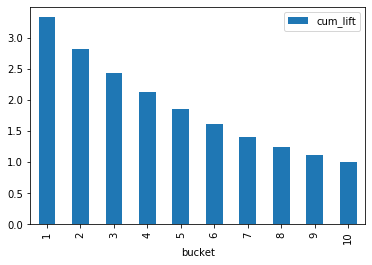

In [0]:
display(model_summary["artifacts"]["lift"].toPandas().plot.bar(x="bucket", y="cum_lift"))

In [0]:
model_summary["artifacts"]

Out[16]: {'coefficients': {'age': {'value': 0.030001202345547904,
 'std_err': 0.002654062371818439,
 't_value': 11.303879917860593,
 'p_value': 0.0},
 'capital_gain': {'value': 0.00032196107659020873,
 'std_err': 1.9678243416633804e-05,
 't_value': 16.361271164989176,
 'p_value': 0.0},
 'capital_loss': {'value': 0.0005931510927276098,
 'std_err': 6.732735917530944e-05,
 't_value': 8.809956308892813,
 'p_value': 0.0},
 'education_num': {'value': 0.3112361482166032,
 'std_err': 0.013469956861771257,
 't_value': 23.105949886143634,
 'p_value': 0.0},
 'fnlwgt': {'value': 7.467751583969285e-08,
 'std_err': 3.093761491092642e-07,
 't_value': 0.2413809728212712,
 'p_value': 0.8092598583162502},
 'hours_per_week': {'value': 0.03437598435723148,
 'std_err': 0.002783851420411058,
 't_value': 12.348354551248137,
 'p_value': 0.0},
 'marital_status_encoded_ Married-civ-spouse': {'value': 0.44381085071953047,
 'std_err': 0.03884638220761187,
 't_value': 11.42476661913105,
 'p_value': 0.0},
 'marital_status_encoded_ Never-married': {'value': -0.250452650889049,
 'std_err': 0.0398945330605005,
 't_value': -6.277868962878567,
 'p_value': 3.4324498798810055e-10},
 'marital_status_encoded_ Divorced': {'value': -0.12282921690779264,
 'std_err': 0.04031392365319154,
 't_value': -3.0468187111841347,
 'p_value': 0.0023127715083162137},
 'marital_status_encoded_ Separated': {'value': -0.02230858306767849,
 'std_err': 0.042630993953964774,
 't_value': -0.5232949316586072,
 'p_value': 0.6007690274808732},
 'marital_status_encoded_ Widowed': {'value': -0.03815077711685274,
 'std_err': 0.042543151404138904,
 't_value': -0.8967548443799854,
 'p_value': 0.3698497481387486},
 'marital_status_encoded_ Married-spouse-absent': {'value': -0.014356676038775001,
 'std_err': 0.04296962351448285,
 't_value': -0.33411221380462186,
 'p_value': 0.738294883877648},
 'race_encoded_ White': {'value': 0.048306109636175126,
 'std_err': 0.03995333914193391,
 't_value': 1.2090631389924147,
 'p_value': 0.22663858926878921},
 'race_encoded_ Black': {'value': -0.04046121572100862,
 'std_err': 0.041249751799963555,
 't_value': -0.9808838588222577,
 'p_value': 0.32665001811927485},
 'race_encoded_ Asian-Pac-Islander': {'value': 0.003433851441538962,
 'std_err': 0.04217588070406497,
 't_value': 0.08141742114724833,
 'p_value': 0.935109995032104},
 'race_encoded_ Amer-Indian-Eskimo': {'value': -0.007050828985248592,
 'std_err': 0.043052757392413446,
 't_value': -0.16377183279998359,
 'p_value': 0.8699107664215755},
 'relationship_encoded_ Husband': {'value': 0.32244485081049545,
 'std_err': 0.03865188292398382,
 't_value': 8.342280541536457,
 'p_value': 0.0},
 'relationship_encoded_ Not-in-family': {'value': -0.19791602496390118,
 'std_err': 0.039241954619444845,
 't_value': -5.04348029763613,
 'p_value': 4.571398577457586e-07},
 'relationship_encoded_ Own-child': {'value': -0.1247604922160323,
 'std_err': 0.04135645345481533,
 't_value': -3.01671158413865,
 'p_value': 0.002555328146456759},
 'relationship_encoded_ Unmarried': {'value': -0.09886633340505431,
 'std_err': 0.04108534944063978,
 't_value': -2.4063646713750515,
 'p_value': 0.01611217229066053},
 'relationship_encoded_ Wife': {'value': 0.12149007007713362,
 'std_err': 0.04157189658146363,
 't_value': 2.9224086478485196,
 'p_value': 0.0034733549453911383},
 'sex_encoded_ Male': {'value': 0.16389593335070637,
 'std_err': 0.03857988504337327,
 't_value': 4.248222439399368,
 'p_value': 2.1547339418059863e-05},
 'workclass_encoded_ Private': {'value': 0.02639468446197644,
 'std_err': 0.037209923132084904,
 't_value': 0.7093453100744829,
 'p_value': 0.4781102172125151},
 'workclass_encoded_ Self-emp-not-inc': {'value': -0.056287805867277094,
 'std_err': 0.04064298612194874,
 't_value': -1.3849328319131442,
 'p_value': 0.1660730066808147},
 'workclass_encoded_ Local-gov': {'value': 0.013439221817102191,
 'std_err': 0.040930824980399794,
 't_value': 0.3283398715647124,
 'p_value': 0.742654700502434},
 'workclass_encoded_ ?': {'v

####3. Parameters
In `model_summary["params"]` we log miscellaneous parameters of interest, currently:
* Under `data_science_functions` the version of the datasciencefunctions package used during tranining
* `model_class` - the pyspark or sci-kit learn class of the model used

In [0]:
model_summary["params"]

Out[17]: {'data_science_functions': {'version': '0.1.1'},
 'model_class': 'pyspark.ml.regressionGeneralizedLinearRegressionModel',
 'model_framework': 'spark'}

# FAQ

We might or might not end up using this

# Where to now?

[Back to the introductory notebook](../classification)

[To the next chapter](02_advanced_do_datasciencing.ipynb)